<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/main/projects/p2/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
%cd /root/.ssh
!cat id_rsa.pub
# then, copy key to github account

In [ ]:
%cd content/drive/MyDrive/git/COMP551/projects/p2
!git pull

# **Mini-Project 2: Optimization and Text Classification**

## PART I: Optimization


In [123]:
import pandas as pd
import numpy as np
import my_gd
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

### Logistic Regression

In [65]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        # gradient
        g = np.inf 
        # timestamp
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad    

### Cost Function

In [66]:
def cost_fn(y, yh):
    J = np.mean(y * np.log1p(np.exp(-yh)) + (1-y) * np.log1p(np.exp(yh)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

### 1. Import Data

In [147]:
train_df, test_df, val_df = pd.read_csv('data/diabetes/diabetes_train.csv'), pd.read_csv('data/diabetes/diabetes_test.csv'),pd.read_csv('data/diabetes/diabetes_val.csv')
x_train, y_train = train_df.iloc[:,:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
x_test, y_test = test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()
x_val, y_val = val_df.iloc[:,:-1].to_numpy(), val_df.iloc[:,-1].to_numpy()

In [148]:
x_train.shape

(600, 8)

### 2. Learning Rate and Number of Iterations Tuning

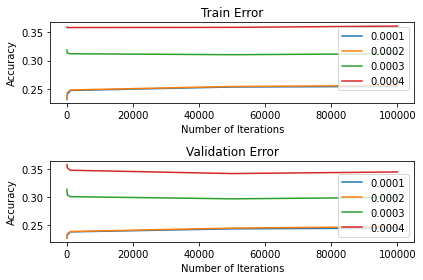

In [162]:

figure, axis = plt.subplots(2, 1)

axis[0].set_title("Train Error")
axis[1].set_title("Validation Error")

lr_range = np.arange(0.0001, 0.0005, 0.0001)
max_iters_range = np.array([10,100,1000,50000,100000])

for i, lr in enumerate(lr_range):
  acc_train_arr = np.zeros((max_iters_range.size))
  acc_val_arr = np.zeros((max_iters_range.size))
  for j, max_iters in enumerate(max_iters_range):
    log_reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=1e-4, max_iters=max_iters, verbose=False)
    log_reg.fit(x_train, y_train)

    # compute error
    acc_train_arr[j] = 1 - cost_fn(log_reg.predict(x_train), y_train)
    acc_val_arr[j] = 1 - cost_fn(log_reg.predict(x_val), y_val)

  # add plot lines
  axis[0].plot(max_iters_range, acc_train_arr, label="%0.4f" % lr)
  axis[1].plot(max_iters_range, acc_val_arr, label="%0.4f" % lr)

for subplot in axis:
  subplot.set_xlabel("Number of Iterations")
  subplot.set_ylabel("Accuracy")
  subplot.legend()
figure.tight_layout()
plt.show()



In [159]:
max_iters_range.size

100